# Lab Five: Wide and Deep Network Architectures

In this lab, you will select a prediction task to perform on your dataset, evaluate two different deep learning architectures and tune hyper-parameters for each architecture. If any part of the assignment is not clear, ask the instructor to clarify. 

This report is worth 10% of the final grade. Please upload a report (<b>one per team</b>) with all code used, visualizations, and text in a rendered Jupyter notebook. Any visualizations that cannot be embedded in the notebook, please provide screenshots of the output. The results should be reproducible using your report. Please carefully describe every assumption and every step in your report.

<b>Dataset Selection</b>

Select a dataset similarly to lab one. That is, the dataset must be table data. In terms of generalization performance, it is helpful to have a large dataset for building a wide and deep network. It is also helpful to have many different categorical features to create the embeddings and cross-product embeddings. It is fine to perform binary classification, multi-class classification, or regression.

## Preparation (4 pts)

<ul>
    <li>[<b>1 points</b>] Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). 
    <li>[<b>1 points</b>] Identify groups of features in your data that should be combined into cross-product features. Provide justification for why these features should be crossed (or why some features should not be crossed).</li>
    <li>[<b>1 points</b>] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a <b>detailed argument for why this (these) metric(s) are appropriate on your data</b>. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.</li>
    <li>[<b>1 points</b>] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). <b>Explain why your chosen method is appropriate or use more than one method as appropriate</b>. Argue why your cross validation method is a realistic mirroring of how an algorithm would be used in practice. </li>
</ul>

### Dataset Preparation & Preprocessing

In [1]:
# Importing packages and reading in dataset
import numpy as np
import pandas as pd

print('Pandas:', pd.__version__)
print('Numpy:',  np.__version__)

Pandas: 1.1.3
Numpy: 1.19.2


In [2]:
#read in csv file
merc_info = pd.read_csv('merc.csv')

#shuffle data
merc_info = merc_info.sample(frac=1)

#no null values, therefore do not need to impute any data
# print(merc_info.info(show_counts=True))

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

merc_info["log_price"] = np.log(merc_info["price"])
del merc_info["price"]

# define objects that can encode each variable as integer
categorical = ["model", "transmission", "fuelType"]
encoders = dict()

# train all encoders
for cat in categorical:
    # integer encoded variables
    encoders[cat] = LabelEncoder() # save the encoder
    merc_info[cat+'_int'] = encoders[cat].fit_transform(merc_info[cat])

# scale the numeric, continuous variables
numerical = ["year", "mileage", "tax", "mpg", "engineSize"]

for num in numerical:
    merc_info[num] = merc_info[num].astype(np.float)
    ss = StandardScaler()
    merc_info[num] = ss.fit_transform(merc_info[num].values.reshape(-1, 1))
    
categorical_headers_ints = [x+'_int' for x in categorical]
feature_columns = categorical_headers_ints + numerical

# Define features and target
X = merc_info.drop("log_price", axis=1)
y = merc_info["log_price"]

# print(merc_info.info(show_counts=True))
merc_info

,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,log_price,model_int,transmission_int,fuelType_int
8024,SL CLASS,0.765843,Automatic,-1.011043,Petrol,0.230284,-1.784279,5.989596,11.287266,19,0,3
7502,C Class,0.765843,Semi-Auto,-0.898462,Diesel,0.230284,0.088318,-0.124964,10.312247,2,3,0
6763,B Class,0.765843,Semi-Auto,-0.901673,Diesel,0.230284,0.324857,-0.998472,10.081592,1,3,0
9245,C Class,-0.582700,Semi-Auto,1.129523,Diesel,-1.531958,0.410273,0.049738,9.804992,2,3,0
12087,E Class,-0.133186,Automatic,1.078332,Diesel,-1.685196,0.797934,-0.124964,9.852194,8,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11998,E Class,-1.032214,Automatic,0.682407,Diesel,-0.076193,0.088318,0.049738,9.710813,8,0,0
12110,GLA Class,-0.133186,Automatic,0.211301,Diesel,-1.531958,0.594248,0.049738,9.740969,11,0,0
3126,E Class,-0.133186,Semi-Auto,0.767079,Diesel,0.230284,1.133030,-0.124964,9.902487,8,3,0
1333,A Class,0.765843,Manual,-0.381926,Petrol,0.230284,-1.751427,-1.347876,9.902987,0,1,3


#### Explanation of Final Data Set
hello

### Making Crossed Columns

In [4]:
cross_columns = [['model', 'fuelType'],
                 ['transmission','fuelType'],
                 ['model','transmission']
                ]

cross_col_names = []
for cols_list in cross_columns:
    enc = LabelEncoder()
    
    X_crossed = merc_info[cols_list].apply(lambda x: '_'.join(x), axis=1)
    
    cross_col_name = '_'.join(cols_list)
    enc.fit(X_crossed)
    
    merc_info[cross_col_name] = enc.transform(X_crossed)
    
    # keep track of the new names of the crossed columns
    cross_col_names.append(cross_col_name)

### Split Dataset into Training and Testing

In [5]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(merc_info,y,test_size=0.2,random_state=123)

X_train_df = pd.DataFrame(X_train, columns= merc_info.columns)
X_test_df = pd.DataFrame(X_test, columns= merc_info.columns)

#### Explanation of Dataset Split
Our dataset is very large; it is made up about about 13,100 instances. Therefore, we are able to split our training and testing data by a 80-20 ratio.

#### Explanation of Evaluation Metrics
MSE cuz regression

## Modeling (5 pts)

<ul>
    <li>[<b>2 points</b>] Create at least three combined wide and deep networks to classify your data using Keras. Visualize the performance of the network on the training data and validation data in the same plot versus the training iterations. Note: use the "history" return parameter that is part of Keras "fit" function to easily access this data. </li> 
    <li>[<b>2 points</b>] Investigate generalization performance by altering the number of layers in the deep branch of the network. Try at least two different number of layers. Use the method of cross validation and evaluation metric that you argued for at the beginning of the lab to select the number of layers that performs superiorly. </li>
    <li>[<b>1 points</b>] Compare the performance of your best wide and deep network to a standard multi-layer perceptron (MLP). For classification tasks, use the receiver operating characteristic and area under the curve. For regression tasks, use Bland-Altman plots and residual variance calculations.  Use proper statistical method to compare the performance of different models.  </li>
</ul>

### Creating the Deep Network

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import Embedding, Flatten, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

optimizer = 'adam'
initializer = tf.keras.initializers.GlorotUniform()
loss = 'mean_squared_error'
metrics = 'mean_squared_error'
epochs = 256
batch_size = 512
verbose = 1
callbacks = [EarlyStopping(monitor='mean_squared_error', patience=8)]

X_train_cat = X_train_df[categorical_headers_ints].to_numpy()
X_train_num = X_train_df[numerical].to_numpy()
X_test_cat  = X_test_df[categorical_headers_ints].to_numpy()
X_test_num  = X_test_df[numerical].to_numpy()

In [7]:
%%time

all_branch_outputs = [] # this is where we will keep track of output of each branch

# feed in the entire matrix of categorical variables
input_cat = Input(shape=(X_train_cat.shape[1],), name='categorical', dtype='int64')

# for each categorical variable
for idx,col in enumerate(categorical_headers_ints):
    
    # what the maximum integer value for this variable?
    # which is the same as the number of categories
    N = max(X_train_df[col].max(),X_test_df[col].max())+1 
    
    # this line of code does this: input_cat[:,idx]
    x = tf.gather(input_cat, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs in list to concatenate later
    all_branch_outputs.append(x)
    
input_num = Input(shape=(X_train_num.shape[1],), name='numeric')
x_dense = Dense(units=10, kernel_initializer=initializer, name='num_1')(input_num)

all_branch_outputs.append(x_dense)
        
# now concatenate the outputs and add a fully connected layer
deep_branch_0 = concatenate(all_branch_outputs, name='deep_concat')
deep_branch_1 = Dense(units=10, kernel_initializer=initializer, name='deep_1')(deep_branch_0)
deep_branch_2 = Dense(units=10, kernel_initializer=initializer, name='deep_2')(deep_branch_1)
deep_branch_3 = Dense(units=10,  kernel_initializer=initializer, name='deep_3')(deep_branch_2)

final_branch = Dense(units=1, name='output')(deep_branch_3)

model = Model(inputs=[input_cat, input_num], outputs=final_branch)

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

history = model.fit([X_train_cat, X_train_num], y_train,
                    epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=callbacks,
                    validation_data=([X_test_cat, X_test_num], y_test))

Epoch 1/256
21/21 [==============================] - 1s 26ms/step - loss: 99.7773 - mean_squared_error: 99.7773 - val_loss: 95.4821 - val_mean_squared_error: 95.4821
Epoch 2/256
21/21 [==============================] - 0s 3ms/step - loss: 93.0651 - mean_squared_error: 93.0651 - val_loss: 83.8151 - val_mean_squared_error: 83.8151
Epoch 3/256
21/21 [==============================] - 0s 3ms/step - loss: 78.3267 - mean_squared_error: 78.3267 - val_loss: 57.3086 - val_mean_squared_error: 57.3086
Epoch 4/256
21/21 [==============================] - 0s 3ms/step - loss: 47.5360 - mean_squared_error: 47.5360 - val_loss: 15.7221 - val_mean_squared_error: 15.7221
Epoch 5/256
21/21 [==============================] - 0s 3ms/step - loss: 8.7692 - mean_squared_error: 8.7692 - val_loss: 0.4623 - val_mean_squared_error: 0.4623
Epoch 6/256
21/21 [==============================] - 0s 3ms/step - loss: 0.6624 - mean_squared_error: 0.6624 - val_loss: 0.0581 - val_mean_squared_error: 0.0581
Epoch 7/256
21/21

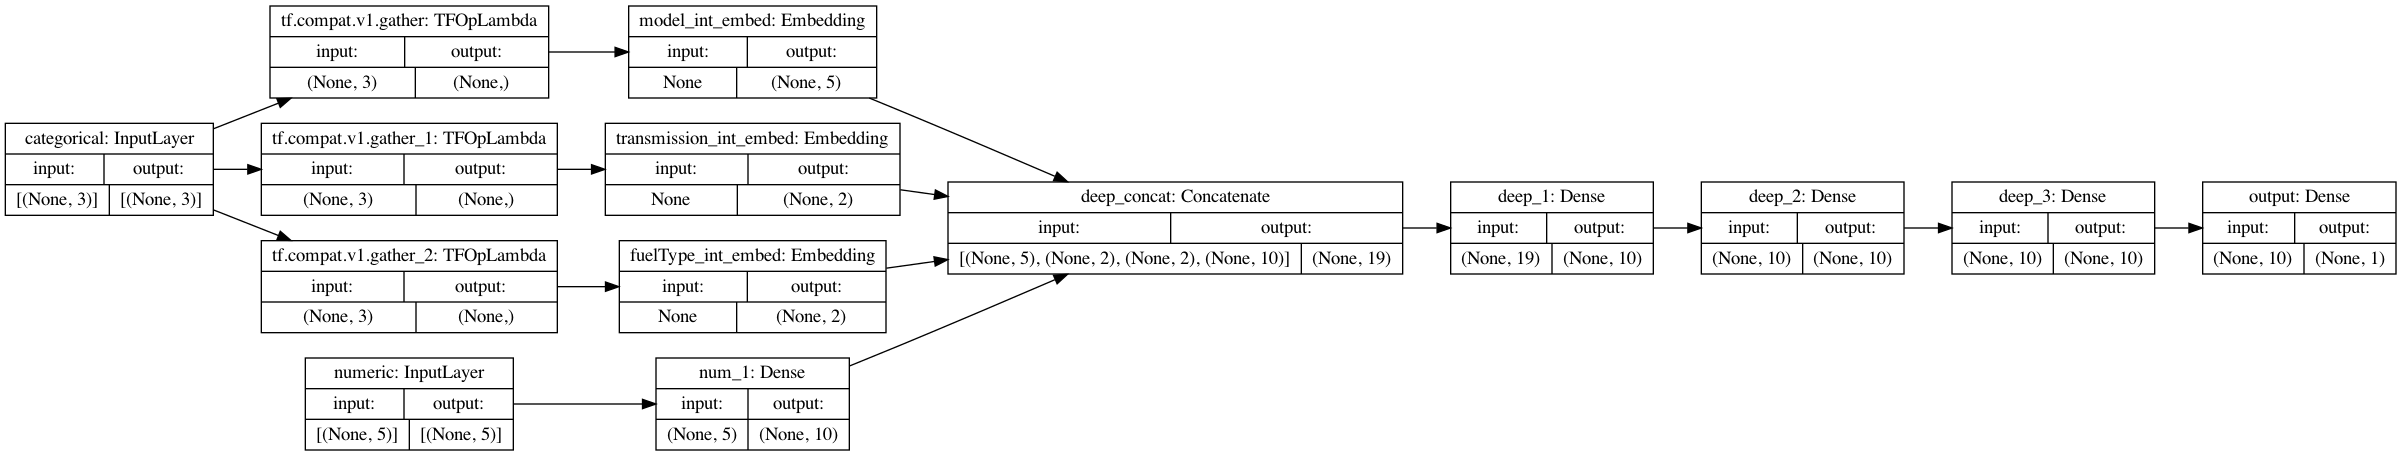

In [8]:
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

Text(0.5, 1.0, 'Validation')

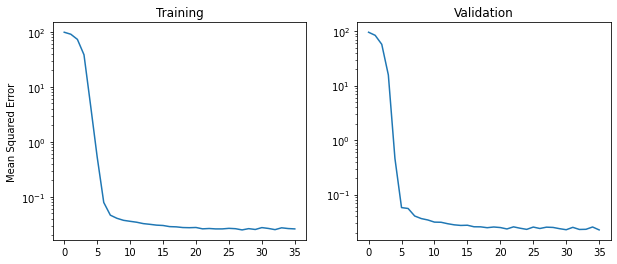

In [9]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.yscale('log')
plt.plot(history.history['mean_squared_error'])
plt.ylabel('Mean Squared Error')

plt.title('Training')
plt.subplot(1,2,2)
plt.yscale('log')
plt.plot(history.history['val_mean_squared_error'])
plt.title('Validation')

### Creating the Wide Networks

In [10]:
def crossed_outputs(idx, input_crossed):
    col = cross_col_names[idx]
    N = merc_info[col].max()+1
    x = tf.gather(input_crossed, 0, axis=1)
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(x)
    return x

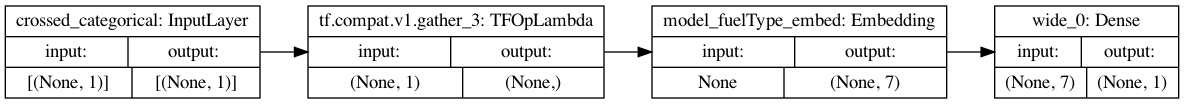

In [11]:
X_train_crossed_0 = X_train_df[cross_col_names[0]].to_numpy()
X_test_crossed_0  = X_test_df[cross_col_names[0]].to_numpy()
input_crossed_0  = Input(shape=(1,), dtype='int64', name='crossed_categorical')
output_crossed_0 = crossed_outputs(0, input_crossed_0)

wide_branch_0 = Dense(units=1, kernel_initializer=initializer, name='wide_0')(output_crossed_0)

model = Model(inputs=input_crossed_0, outputs=wide_branch_0)
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

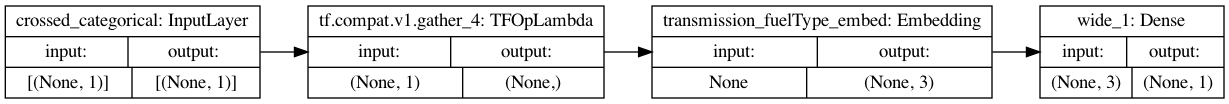

In [12]:
X_train_crossed_1 = X_train_df[cross_col_names[1]].to_numpy()
X_test_crossed_1  = X_test_df[cross_col_names[1]].to_numpy()
input_crossed_1  = Input(shape=(1,), dtype='int64', name='crossed_categorical')
output_crossed_1 = crossed_outputs(1, input_crossed_1)

wide_branch_1 = Dense(units=1, kernel_initializer=initializer, name='wide_1')(output_crossed_1)

model = Model(inputs=input_crossed_1, outputs=wide_branch_1)
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

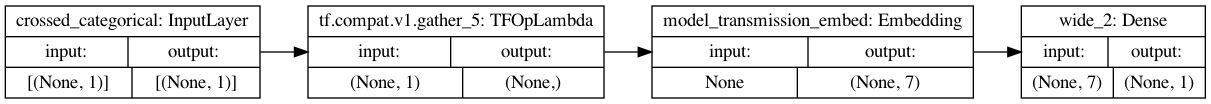

In [13]:
X_train_crossed_2 = X_train_df[cross_col_names[2]].to_numpy()
X_test_crossed_2  = X_test_df[cross_col_names[2]].to_numpy()
input_crossed_2  = Input(shape=(1,), dtype='int64', name='crossed_categorical')
output_crossed_2 = crossed_outputs(2, input_crossed_2)

wide_branch_2 = Dense(units=1, kernel_initializer=initializer, name='wide_2')(output_crossed_2)

model = Model(inputs=input_crossed_2, outputs=wide_branch_2)
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

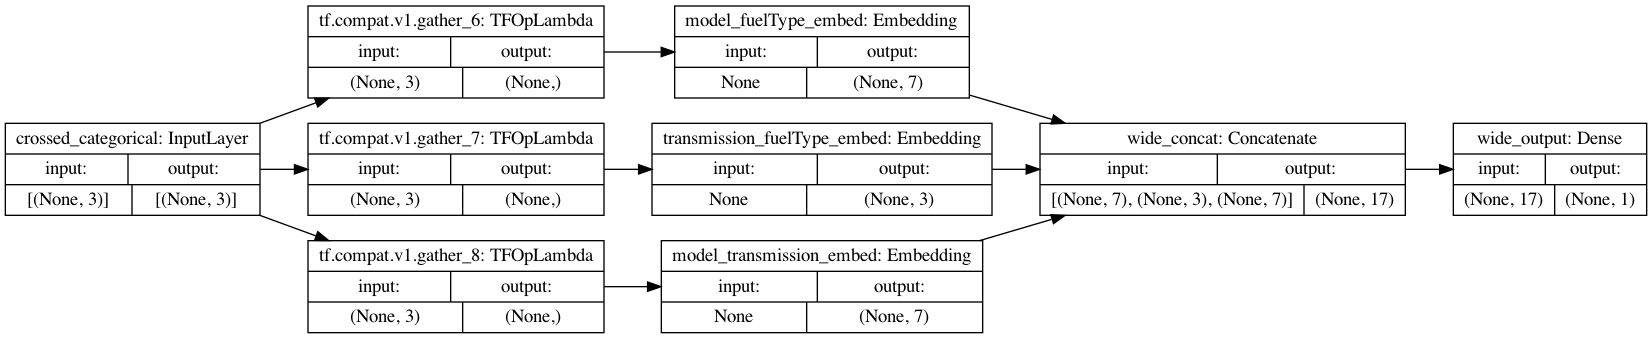

In [14]:
X_train_crossed = X_train_df[cross_col_names].to_numpy()
X_test_crossed  = X_test_df[cross_col_names].to_numpy()

output_crossed = []
input_crossed = Input(shape=(X_train_crossed.shape[1],), dtype='int64', name='crossed_categorical')
for idx,col in enumerate(cross_col_names):
    N = merc_info[col].max()+1
    x = tf.gather(input_crossed, idx, axis=1)
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(x)
    output_crossed.append(x)

wide_branch = concatenate(output_crossed, name='wide_concat')
wide_branch_output = Dense(units=1, kernel_initializer=initializer, name='wide_output')(wide_branch)

model = Model(inputs=input_crossed, outputs=wide_branch_output)
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

### Combining the Networks

In [15]:
wide_deep_0 = concatenate([output_crossed_0, deep_branch_3], axis=1)
wide_deep_0 = Dense(units=1, kernel_initializer=initializer)(wide_deep_0)
model = Model(inputs=[input_crossed_0, input_cat, input_num], outputs=wide_deep_0)
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = model.fit([X_train_crossed_0, X_train_cat, X_train_num], y_train,
                    epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=callbacks,
                    validation_data=([X_test_crossed_0, X_test_cat, X_test_num], y_test))

Epoch 1/256
21/21 [==============================] - 1s 9ms/step - loss: 46.6912 - mean_squared_error: 46.6912 - val_loss: 20.6305 - val_mean_squared_error: 20.6305
Epoch 2/256
21/21 [==============================] - 0s 3ms/step - loss: 14.0206 - mean_squared_error: 14.0206 - val_loss: 0.8826 - val_mean_squared_error: 0.8826
Epoch 3/256
21/21 [==============================] - 0s 3ms/step - loss: 0.3639 - mean_squared_error: 0.3639 - val_loss: 0.3159 - val_mean_squared_error: 0.3159
Epoch 4/256
21/21 [==============================] - 0s 3ms/step - loss: 0.2003 - mean_squared_error: 0.2003 - val_loss: 0.0319 - val_mean_squared_error: 0.0319
Epoch 5/256
21/21 [==============================] - 0s 3ms/step - loss: 0.0395 - mean_squared_error: 0.0395 - val_loss: 0.0259 - val_mean_squared_error: 0.0259
Epoch 6/256
21/21 [==============================] - 0s 3ms/step - loss: 0.0313 - mean_squared_error: 0.0313 - val_loss: 0.0240 - val_mean_squared_error: 0.0240
Epoch 7/256
21/21 [=========

Text(0.5, 1.0, 'Validation')

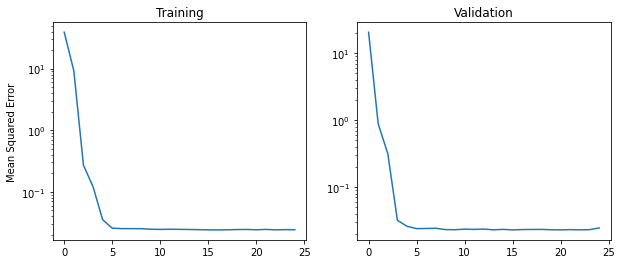

In [16]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.yscale('log')
plt.plot(history.history['mean_squared_error'])
plt.ylabel('Mean Squared Error')

plt.title('Training')
plt.subplot(1,2,2)
plt.yscale('log')
plt.plot(history.history['val_mean_squared_error'])
plt.title('Validation')

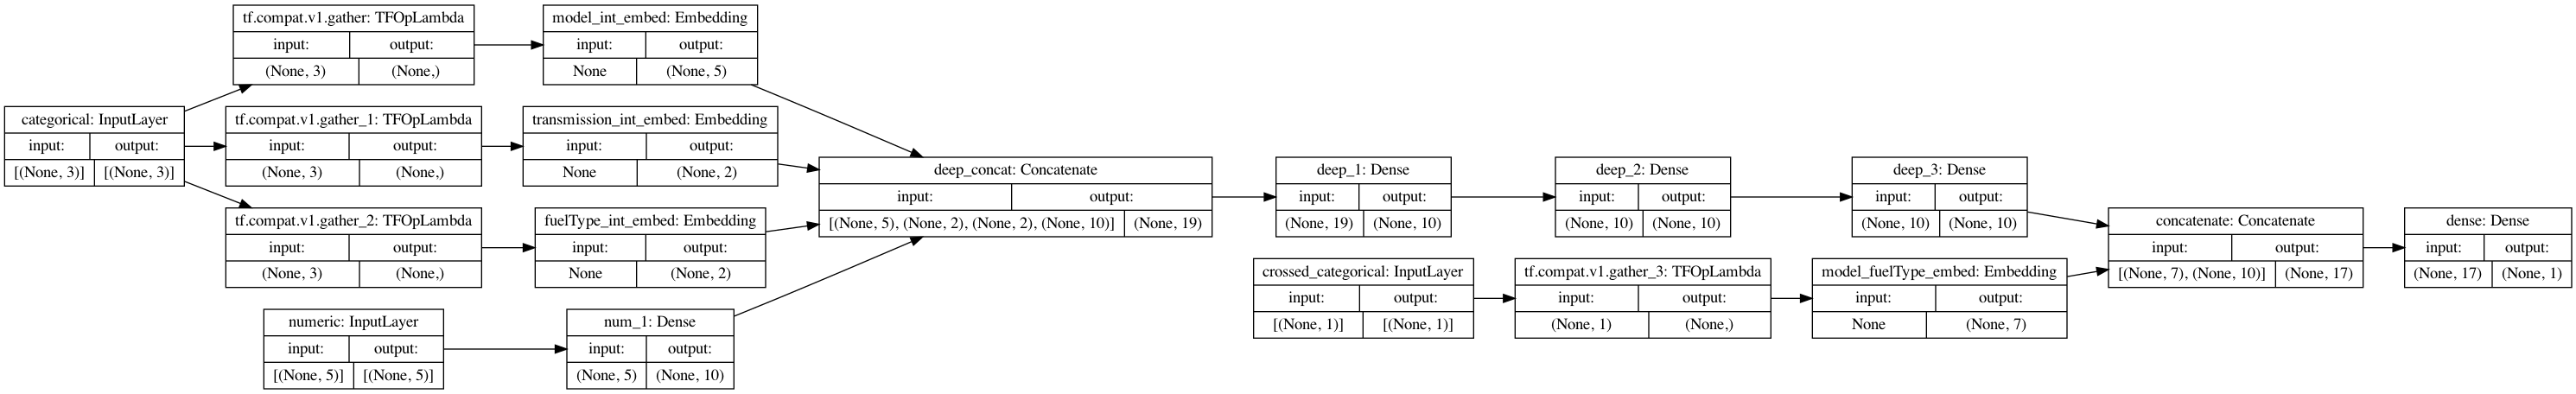

In [17]:
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [18]:
wide_deep_1 = concatenate([output_crossed_1, deep_branch_3], axis=1)
wide_deep_1 = Dense(units=1, kernel_initializer=initializer)(wide_deep_1)
model = Model(inputs=[input_crossed_1, input_cat, input_num], outputs=wide_deep_1)
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = model.fit([X_train_crossed_1, X_train_cat, X_train_num], y_train,
                    epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=callbacks,
                    validation_data=([X_test_crossed_1, X_test_cat, X_test_num], y_test))

Epoch 1/256
21/21 [==============================] - 1s 9ms/step - loss: 141.1269 - mean_squared_error: 141.1269 - val_loss: 95.9548 - val_mean_squared_error: 95.9548
Epoch 2/256
21/21 [==============================] - 0s 3ms/step - loss: 84.2896 - mean_squared_error: 84.2896 - val_loss: 52.6150 - val_mean_squared_error: 52.6150
Epoch 3/256
21/21 [==============================] - 0s 2ms/step - loss: 43.0175 - mean_squared_error: 43.0175 - val_loss: 16.8900 - val_mean_squared_error: 16.8900
Epoch 4/256
21/21 [==============================] - 0s 3ms/step - loss: 11.1612 - mean_squared_error: 11.1612 - val_loss: 0.6725 - val_mean_squared_error: 0.6725
Epoch 5/256
21/21 [==============================] - 0s 3ms/step - loss: 0.2727 - mean_squared_error: 0.2727 - val_loss: 0.1938 - val_mean_squared_error: 0.1938
Epoch 6/256
21/21 [==============================] - 0s 2ms/step - loss: 0.1512 - mean_squared_error: 0.1512 - val_loss: 0.0261 - val_mean_squared_error: 0.0261
Epoch 7/256
21/21 

Text(0.5, 1.0, 'Validation')

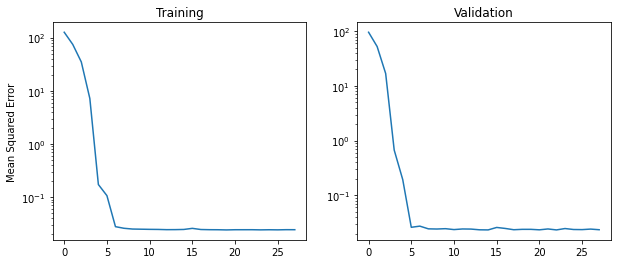

In [19]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.yscale('log')
plt.plot(history.history['mean_squared_error'])
plt.ylabel('Mean Squared Error')

plt.title('Training')
plt.subplot(1,2,2)
plt.yscale('log')
plt.plot(history.history['val_mean_squared_error'])
plt.title('Validation')

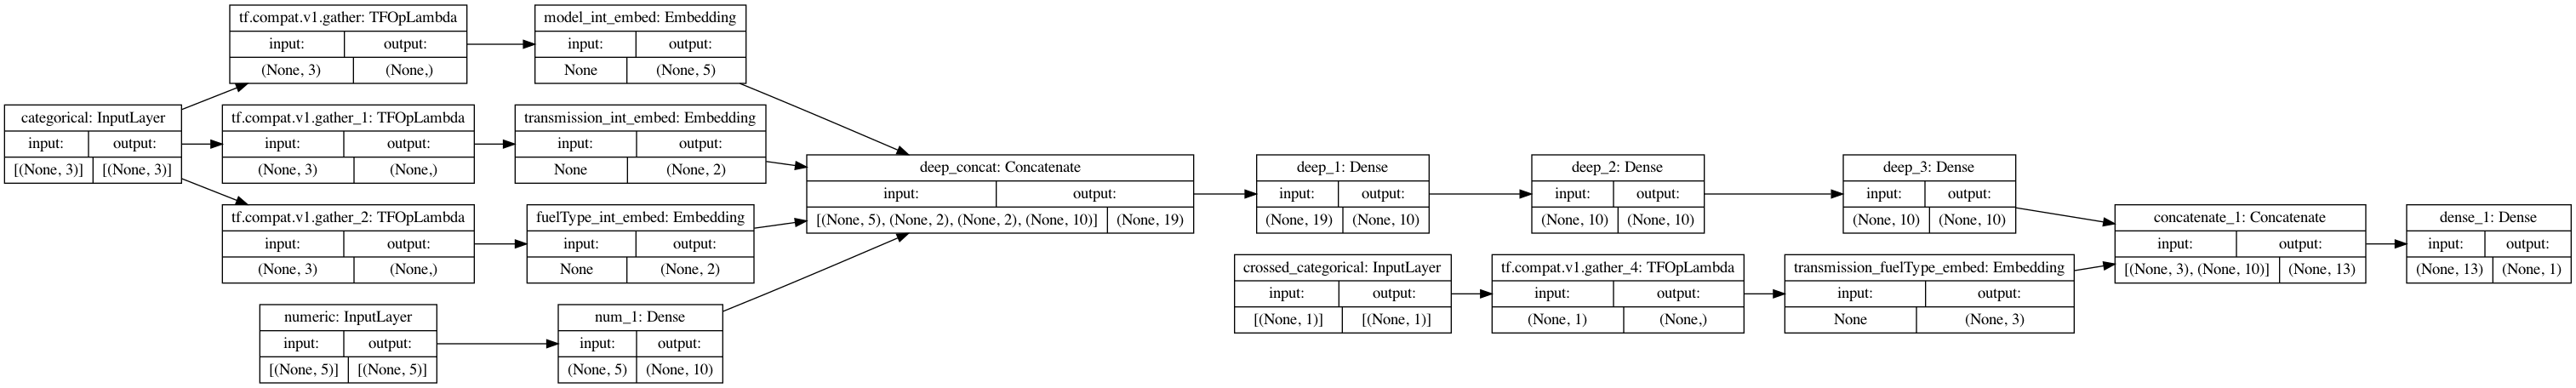

In [20]:
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [21]:
wide_deep_2 = concatenate([output_crossed_2, deep_branch_3], axis=1)
wide_deep_2 = Dense(units=1, kernel_initializer=initializer)(wide_deep_2)
model = Model(inputs=[input_crossed_2, input_cat, input_num], outputs=wide_deep_2)
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = model.fit([X_train_crossed_2, X_train_cat, X_train_num], y_train,
                    epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=callbacks,
                    validation_data=([X_test_crossed_2, X_test_cat, X_test_num], y_test))

Epoch 1/256
21/21 [==============================] - 1s 8ms/step - loss: 475.4631 - mean_squared_error: 475.4631 - val_loss: 334.3450 - val_mean_squared_error: 334.3450
Epoch 2/256
21/21 [==============================] - 0s 3ms/step - loss: 303.8615 - mean_squared_error: 303.8615 - val_loss: 233.4845 - val_mean_squared_error: 233.4845
Epoch 3/256
21/21 [==============================] - 0s 2ms/step - loss: 217.5952 - mean_squared_error: 217.5952 - val_loss: 178.4001 - val_mean_squared_error: 178.4001
Epoch 4/256
21/21 [==============================] - 0s 3ms/step - loss: 168.3414 - mean_squared_error: 168.3414 - val_loss: 142.2493 - val_mean_squared_error: 142.2493
Epoch 5/256
21/21 [==============================] - 0s 3ms/step - loss: 134.6293 - mean_squared_error: 134.6293 - val_loss: 114.1779 - val_mean_squared_error: 114.1779
Epoch 6/256
21/21 [==============================] - 0s 2ms/step - loss: 107.3627 - mean_squared_error: 107.3627 - val_loss: 89.3095 - val_mean_squared_err

Text(0.5, 1.0, 'Validation')

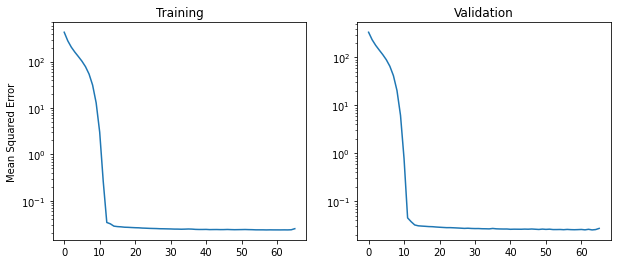

In [22]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.yscale('log')
plt.plot(history.history['mean_squared_error'])
plt.ylabel('Mean Squared Error')

plt.title('Training')
plt.subplot(1,2,2)
plt.yscale('log')
plt.plot(history.history['val_mean_squared_error'])
plt.title('Validation')

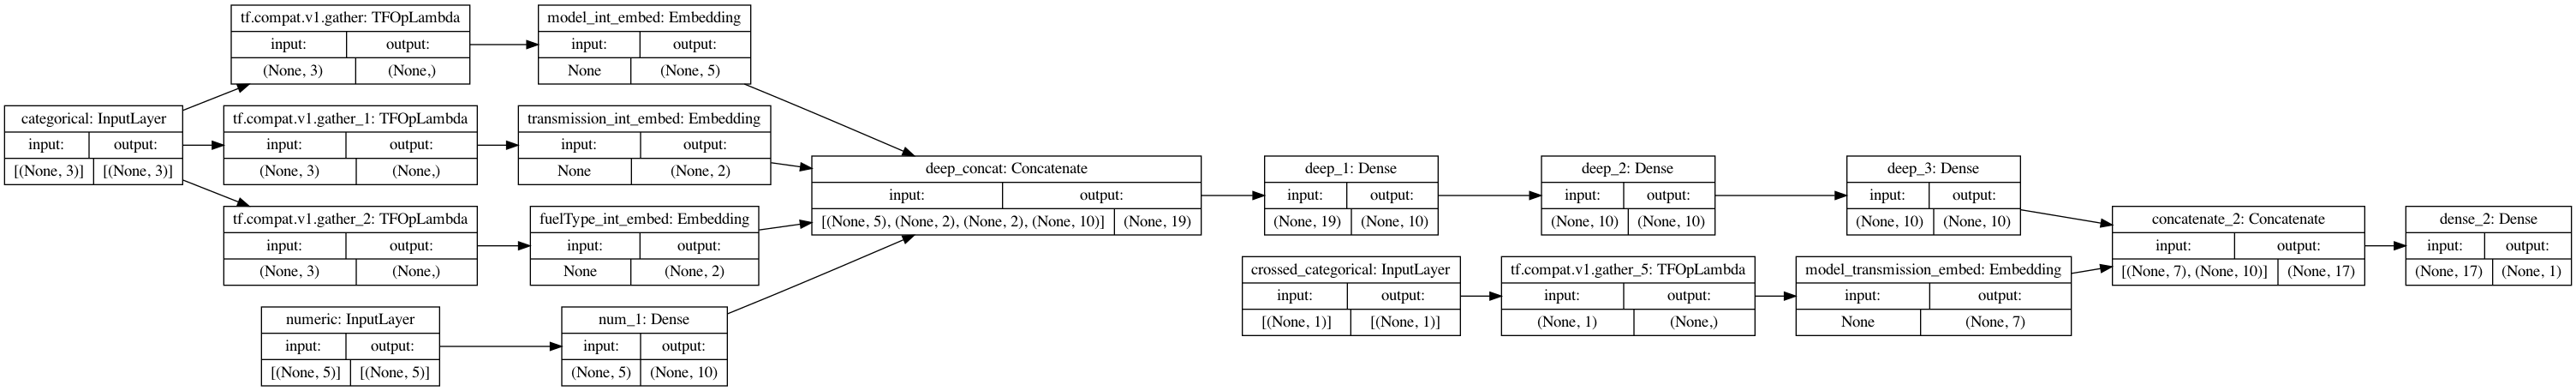

In [23]:
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [24]:
wide_deep = concatenate([wide_branch, deep_branch_3], axis=1)
wide_deep = Dense(units=1, kernel_initializer=initializer)(wide_deep)
model = Model(inputs=[input_crossed, input_cat, input_num], outputs=wide_deep)
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = model.fit([X_train_crossed, X_train_cat, X_train_num], y_train,
                    epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=callbacks,
                    validation_data=([X_test_crossed, X_test_cat, X_test_num], y_test))

Epoch 1/256
21/21 [==============================] - 1s 9ms/step - loss: 35.5176 - mean_squared_error: 35.5176 - val_loss: 7.2135 - val_mean_squared_error: 7.2135
Epoch 2/256
21/21 [==============================] - 0s 3ms/step - loss: 3.5762 - mean_squared_error: 3.5762 - val_loss: 0.3391 - val_mean_squared_error: 0.3391
Epoch 3/256
21/21 [==============================] - 0s 3ms/step - loss: 0.3789 - mean_squared_error: 0.3789 - val_loss: 0.0393 - val_mean_squared_error: 0.0393
Epoch 4/256
21/21 [==============================] - 0s 2ms/step - loss: 0.0354 - mean_squared_error: 0.0354 - val_loss: 0.0369 - val_mean_squared_error: 0.0369
Epoch 5/256
21/21 [==============================] - 0s 3ms/step - loss: 0.0288 - mean_squared_error: 0.0288 - val_loss: 0.0259 - val_mean_squared_error: 0.0259
Epoch 6/256
21/21 [==============================] - 0s 3ms/step - loss: 0.0271 - mean_squared_error: 0.0271 - val_loss: 0.0253 - val_mean_squared_error: 0.0253
Epoch 7/256
21/21 [=============

Text(0.5, 1.0, 'Validation')

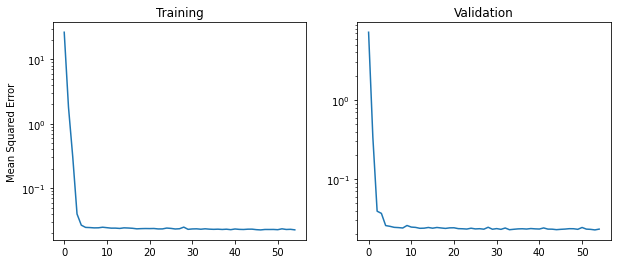

In [25]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.yscale('log')
plt.plot(history.history['mean_squared_error'])
plt.ylabel('Mean Squared Error')

plt.title('Training')
plt.subplot(1,2,2)
plt.yscale('log')
plt.plot(history.history['val_mean_squared_error'])
plt.title('Validation')

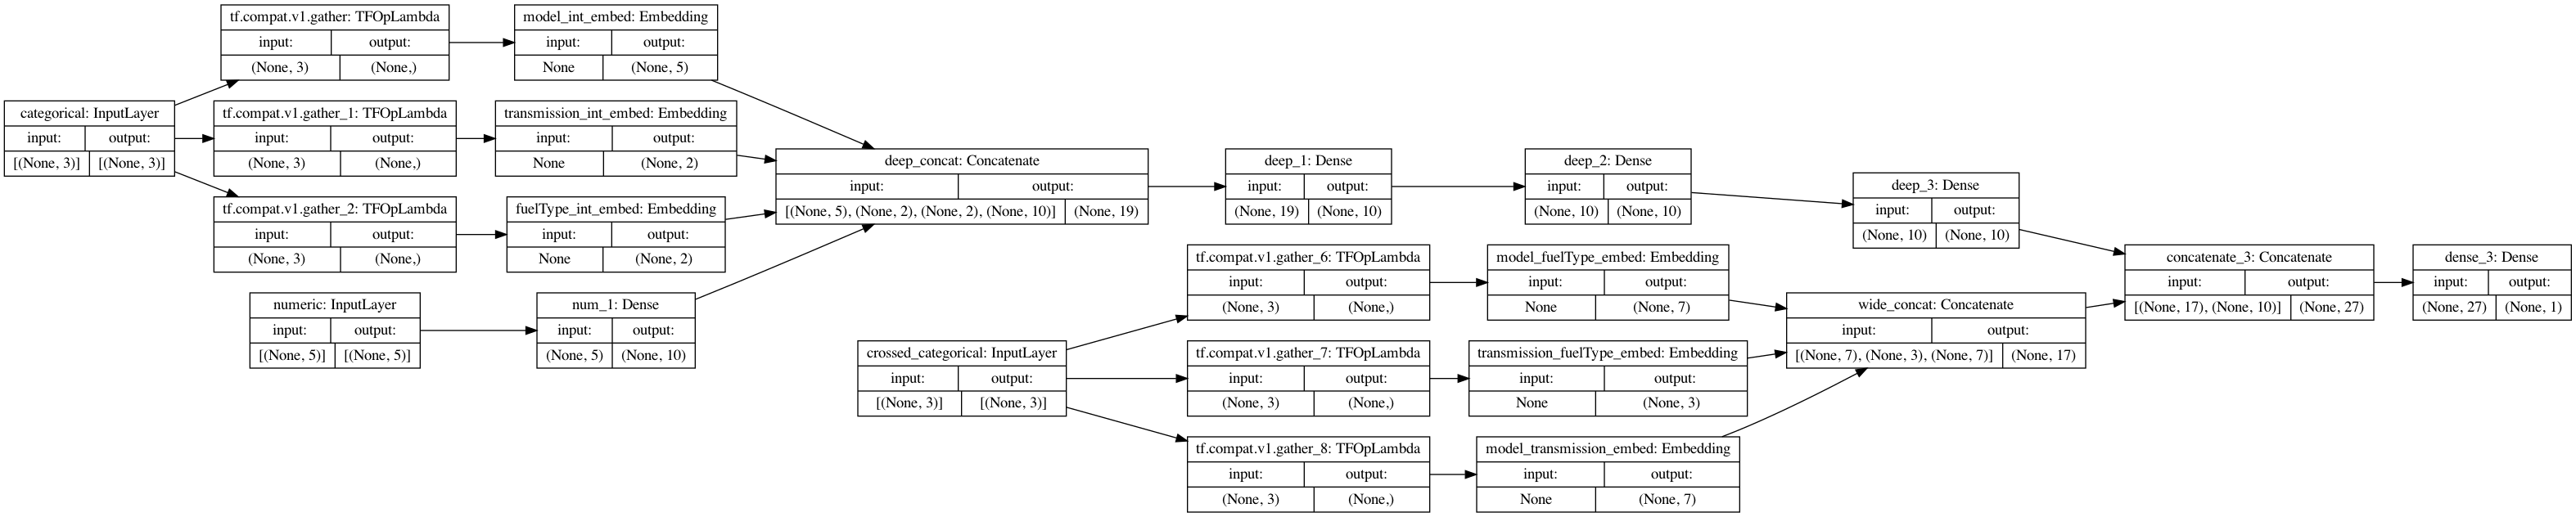

In [26]:
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

### Altering the Number of Layers

#### Cross Validation

In [27]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=10, shuffle=True, random_state=1234)

X_crossed = merc_info[cross_col_names].to_numpy()
X_cat     = merc_info[categorical_headers_ints].to_numpy()
X_num     = merc_info[numerical].to_numpy()
y         = merc_info['log_price'].to_numpy()

deep_branches = [
    deep_branch_0,
    deep_branch_1,
    deep_branch_2,
    deep_branch_3
]

eval_scores = {}
for model_no, deep_branch in enumerate(deep_branches):
    
    fold_no = 0
    eval_scores[model_no] = []
    for train_index, test_index in kf.split(X, y):
        X_train_crossed, X_test_crossed = X_crossed[train_index], X_crossed[test_index]
        X_train_cat,     X_test_cat     = X_cat[train_index],     X_cat[test_index]
        X_train_num,     X_test_num     = X_num[train_index],     X_num[test_index]
        y_train,         y_test         = y[train_index],         y[test_index]
        
        wide_deep = concatenate([wide_branch, deep_branch], axis=1)
        wide_deep = Dense(units=1, kernel_initializer=initializer)(wide_deep)
        model = Model(inputs=[input_crossed, input_cat, input_num], outputs=wide_deep)
        model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        history = model.fit([X_train_crossed, X_train_cat, X_train_num], y_train,
                            epochs=epochs, batch_size=batch_size, callbacks = callbacks, verbose=0)

        scores = model.evaluate([X_test_crossed, X_test_cat, X_test_num], y_test, verbose=0)
        print(f"SCORE FOR MODEL {model_no} FOLD {fold_no}: MSE = {round(scores[1], 5)})")
        
        eval_scores[model_no].append(scores[1])
    
        fold_no += 1
    print(f"MEAN SCORE FOR MODEL {model_no}: MSE = {round(np.mean(eval_scores[model_no]), 5)}")

SCORE FOR MODEL 0 FOLD 0: MSE = 0.04314)
SCORE FOR MODEL 0 FOLD 1: MSE = 0.02525)
SCORE FOR MODEL 0 FOLD 2: MSE = 0.01869)
SCORE FOR MODEL 0 FOLD 3: MSE = 0.02373)
SCORE FOR MODEL 0 FOLD 4: MSE = 0.02167)
SCORE FOR MODEL 0 FOLD 5: MSE = 0.01993)
SCORE FOR MODEL 0 FOLD 6: MSE = 0.01992)
SCORE FOR MODEL 0 FOLD 7: MSE = 0.01776)
SCORE FOR MODEL 0 FOLD 8: MSE = 0.02108)
SCORE FOR MODEL 0 FOLD 9: MSE = 0.04421)
MEAN SCORE FOR MODEL 0: MSE = 0.02554
SCORE FOR MODEL 1 FOLD 0: MSE = 0.01799)
SCORE FOR MODEL 1 FOLD 1: MSE = 0.02202)
SCORE FOR MODEL 1 FOLD 2: MSE = 0.01871)
SCORE FOR MODEL 1 FOLD 3: MSE = 0.02384)
SCORE FOR MODEL 1 FOLD 4: MSE = 0.02103)
SCORE FOR MODEL 1 FOLD 5: MSE = 0.01945)
SCORE FOR MODEL 1 FOLD 6: MSE = 0.0203)
SCORE FOR MODEL 1 FOLD 7: MSE = 0.01772)
SCORE FOR MODEL 1 FOLD 8: MSE = 0.02108)
SCORE FOR MODEL 1 FOLD 9: MSE = 0.04431)
MEAN SCORE FOR MODEL 1: MSE = 0.02264
SCORE FOR MODEL 2 FOLD 0: MSE = 0.01625)
SCORE FOR MODEL 2 FOLD 1: MSE = 0.02233)
SCORE FOR MODEL 2 FOLD 

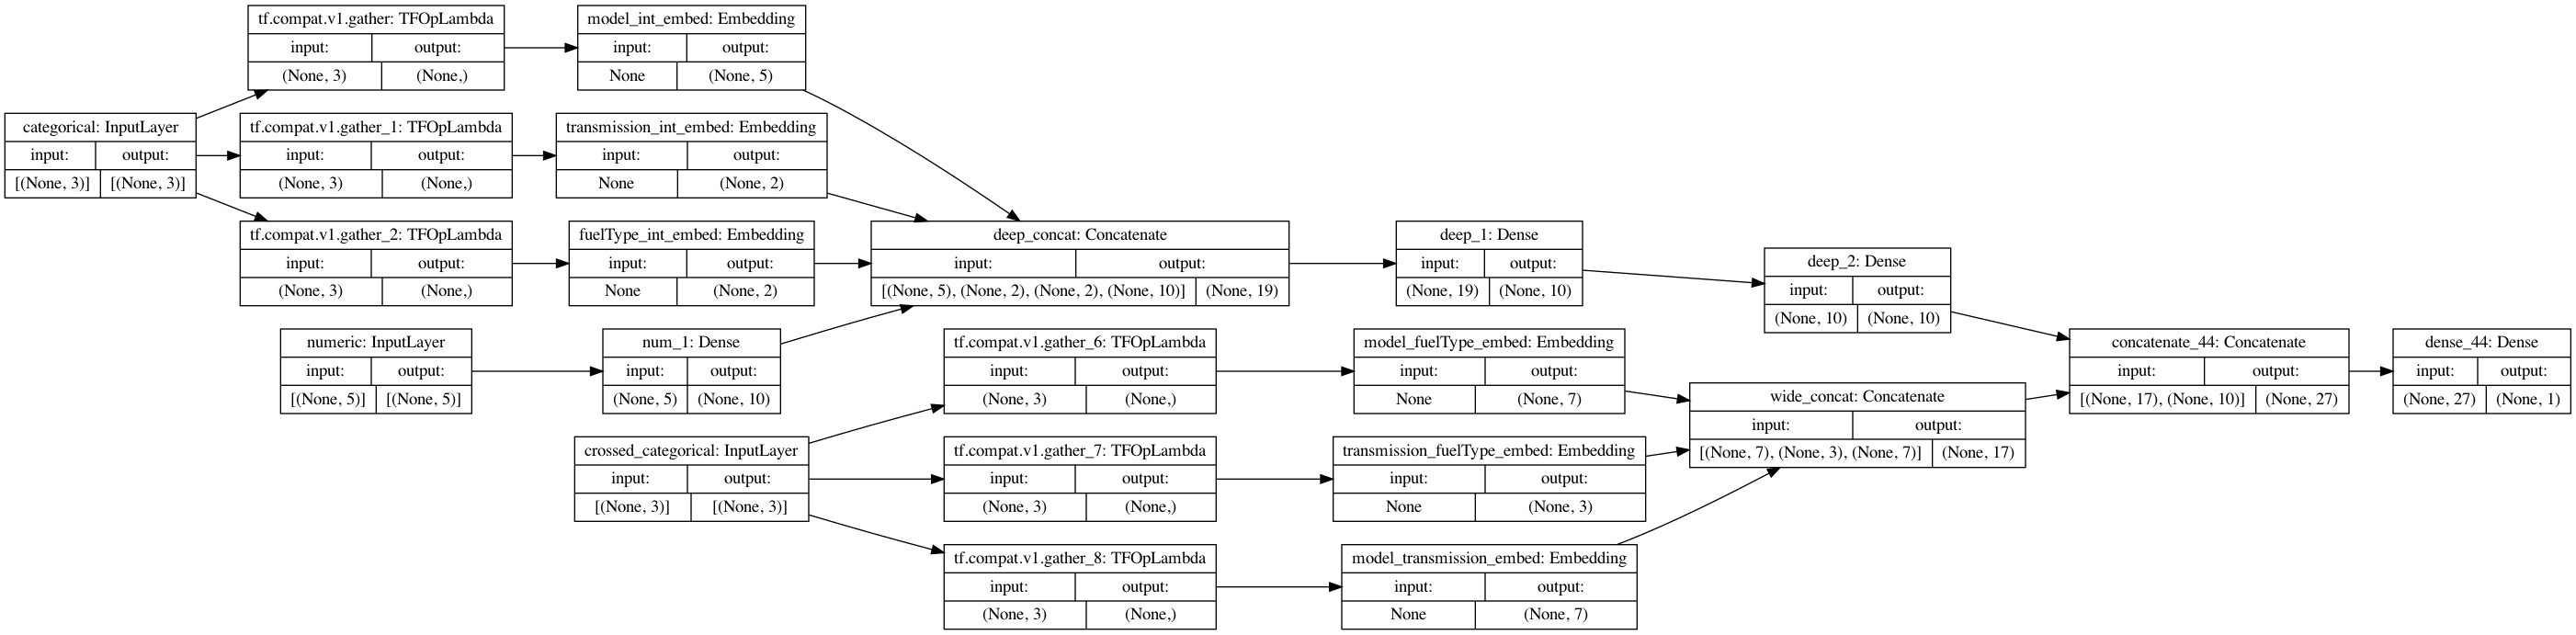

In [28]:
scores = [np.mean(eval_scores[k]) for k in eval_scores]
best_model = np.argmin(scores)

wide_deep = concatenate([wide_branch, deep_branches[best_model]], axis=1)
wide_deep = Dense(units=1, kernel_initializer=initializer)(wide_deep)
best_model = Model(inputs=[input_crossed, input_cat, input_num], outputs=wide_deep)
best_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

plot_model(
    best_model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [29]:
from tensorflow.keras import Sequential

tf.keras.backend.set_floatx('float64')
X_mlp = merc_info[numerical]

for col in categorical_headers_ints:
    X_mlp = pd.concat([X_mlp,pd.get_dummies(merc_info[col], prefix=col)],axis=1)
    
X_mlp = X_mlp.to_numpy()

fold_no = 0
mlp_scores = []
for train_index, test_index in kf.split(X_mlp, y):
    X_train, X_test = X_mlp[train_index], X_mlp[test_index]
    y_train, y_test = y[train_index], y[test_index]

    mlp = Sequential()
    mlp.add(Dense(20, kernel_initializer=initializer))
    mlp.add(Dense(10, kernel_initializer=initializer))
    mlp.add(Dense(5, kernel_initializer=initializer))
    mlp.add(Dense(1, kernel_initializer=initializer))
    mlp.compile(optimizer=optimizer, loss=loss, metrics = metrics)
    history = mlp.fit(X_train, y_train,
                        epochs=epochs, batch_size=batch_size, callbacks = callbacks, verbose=0)

    scores = mlp.evaluate(X_test, y_test, verbose=0)
    print(f"SCORE FOR MODEL MLP FOLD {fold_no}: MSE = {round(scores[1], 5)})")

    mlp_scores.append(scores[1])

    fold_no += 1
    
print("MEAN SCORE FOR MODEL MLP: MSE =",np.mean(mlp_scores))

SCORE FOR MODEL MLP FOLD 0: MSE = 0.01801)
SCORE FOR MODEL MLP FOLD 1: MSE = 0.02441)
SCORE FOR MODEL MLP FOLD 2: MSE = 0.02017)
SCORE FOR MODEL MLP FOLD 3: MSE = 0.03049)
SCORE FOR MODEL MLP FOLD 4: MSE = 0.02909)
SCORE FOR MODEL MLP FOLD 5: MSE = 0.02726)
SCORE FOR MODEL MLP FOLD 6: MSE = 0.02159)
SCORE FOR MODEL MLP FOLD 7: MSE = 0.01954)
SCORE FOR MODEL MLP FOLD 8: MSE = 0.02229)
SCORE FOR MODEL MLP FOLD 9: MSE = 0.04696)
MEAN SCORE FOR MODEL MLP: MSE = 0.02598153930018281


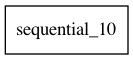

In [30]:
mlp = Sequential()
mlp.add(Dense(20, kernel_initializer=initializer))
mlp.add(Dense(10, kernel_initializer=initializer))
mlp.add(Dense(5, kernel_initializer=initializer))
mlp.add(Dense(1, kernel_initializer=initializer))
mlp.compile(optimizer=optimizer, loss=loss, metrics = metrics)

plot_model(
    mlp, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [31]:
best_model.fit([X_crossed, X_cat, X_num], y, validation_split=.2,
               epochs=epochs, batch_size=batch_size, verbose=0, callbacks=callbacks)
mlp.fit(X_mlp, y, validation_split=.2,
               epochs=epochs, batch_size=batch_size, verbose=0, callbacks=callbacks)

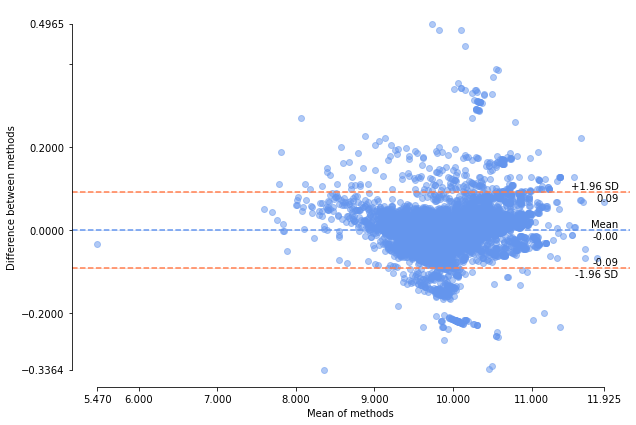

In [32]:
from pyCompare import blandAltman

data_1 = best_model.predict([X_crossed, X_cat, X_num]).reshape(-1)
data_2 = mlp.predict(X_mlp).reshape(-1)

blandAltman(data_1, data_2)

Looking at Bland-Altman plot, we can see that most of the data points are within the statistical error range. Less than 50% of the points lie outside of the range, indicating that there is some agreement between the tests. There is great clustering in the same area, except for a few outliers, so we can assume that the two models are fairly similar.  With the points outside of the range, we can assume there is still slight difference between the two models.

R^2:  0.9871835528701507


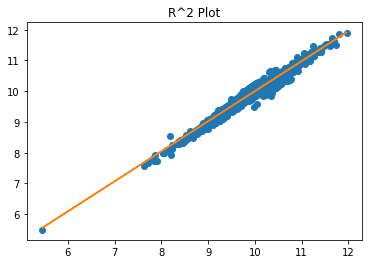

Residual Variance: 0.012816447129849307


In [82]:
from sklearn import metrics as mt

r2 = mt.r2_score(data_1, data_2)
fig, ax = plt.subplots()

plt.plot(data_1, data_2, 'o')
ax.set_title('R^2 Plot')
print("R^2: ", r2)

m, b = np.polyfit(data_1, data_2, 1)
plt.plot(data_1, m*data_1 + b)
plt.show()

print("Residual Variance: " + str(1 - r2))

From the R^2 plot, we can calculate the residual variance to be about 0.0128%, meaning there is a very small amount of error because of the different models.

## Exceptional Work (1 pt)

<ul>
    <li> 5000 students: You have free reign to provide additional analyses. </li> 
    <li>One idea (<b>required for 7000 level students</b>): Capture the embedding weights from the deep network and (<b>if needed</b>) perform dimensionality reduction on the output of these embedding layers (<b>only if needed</b>). That is, pass the observations into the network, save the embedded weights (called embeddings), and then perform  dimensionality reduction in order to visualize results. Visualize and explain any clusters in the data. </li>
</ul>

Embedding Categories:  ['model_int_embed', 'transmission_int_embed', 'fuelType_int_embed']


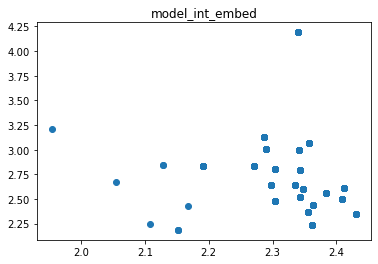

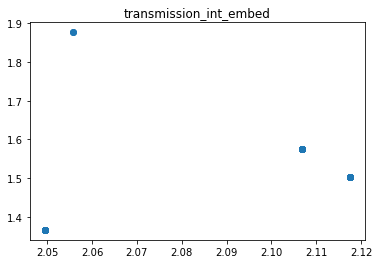

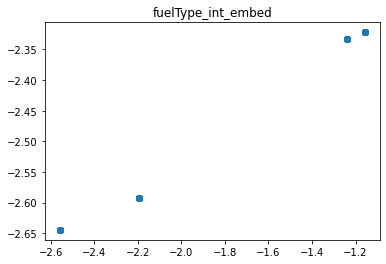

In [34]:
embeddings = []

# for each categorical variable
for col in categorical_headers_ints:
    name = col+'_embed'
    embeddings.append(name)
print("Embedding Categories: ", embeddings)
    
for cat in embeddings:
    temp_model = Model(inputs=model.input, outputs=model.get_layer(cat).output)
    out = temp_model.predict([X_crossed, X_cat, X_num])
    plt.title(cat)
    plt.scatter(out.T[0], out.T[1])
    plt.show()

Looking at these plots, we can see how the number of instances of each feature to help us understand how they relate to the prediction. For instance, model seems to have the largest number of instances, relating to the number of different types of model found in our dataset. We can analyze the clusters of each feature by plotting the embedding weights using TSNE below.

In [74]:
from sklearn.manifold import TSNE
weights = []
for layer in best_model.layers:
    if layer.name[:-6] in categorical_headers_ints:
        weights.append(layer.get_weights())

#extract weight vectors
weights = [w[0] for w in weights]
print(weights)

#t-sne on embedded weights
tsne = TSNE(n_components=2, random_state=2, verbose=1)
reduced_w = []
for embed in weights:
    tsne_w = tsne.fit_transform(embed)
    reduced_w.append(tsne_w)

[array([[ 2.3548024 ,  2.372432  , -1.1197648 ,  0.7650626 , -1.9910525 ],
       [ 2.3620622 ,  2.2364428 , -1.0463712 ,  0.6656203 , -1.9070885 ],
       [ 2.3426545 ,  2.5150483 , -1.1506181 ,  0.81675047, -2.0379245 ],
       [ 2.383237  ,  2.5555875 , -1.1065502 ,  0.8958618 , -2.0997846 ],
       [ 2.4124842 ,  2.6070244 , -1.0614347 ,  0.9595028 , -2.1529815 ],
       [ 2.1514416 ,  2.1859496 , -1.2989298 ,  0.41735938, -1.704136  ],
       [ 2.4308336 ,  2.347872  , -1.1017601 ,  0.76850325, -1.8781457 ],
       [ 2.298263  ,  2.6409698 , -1.2498366 ,  0.852886  , -2.1335375 ],
       [ 2.3474236 ,  2.6020727 , -1.19951   ,  0.8804252 , -2.1528914 ],
       [ 2.3391702 ,  4.191647  , -1.5573891 ,  1.8667145 , -3.011535  ],
       [ 2.3426027 ,  2.797257  , -1.1736529 ,  0.96053016, -2.2361445 ],
       [ 2.3630342 ,  2.4381719 , -1.1023045 ,  0.7759563 , -2.0476682 ],
       [ 2.1908941 ,  2.8309605 , -1.3365533 ,  0.8798579 , -2.1912994 ],
       [ 2.3038256 ,  2.8028126 , -1.

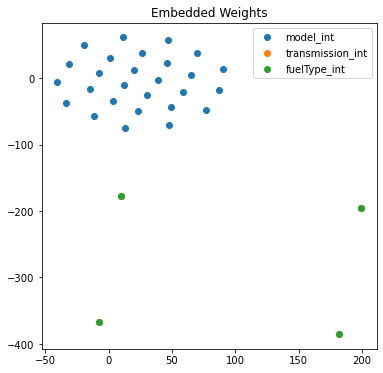

In [55]:
#plot embedded weights
plt.figure(figsize=(6, 6))
for i, w in enumerate(reduced_w):    
    plt.scatter(w[:,0], w[:,1], label=categorical_headers_ints[i])
plt.title('Embedded Weights')
plt.legend()
plt.show()

Using t-SNE on the embedded weights, we can map multi-dimensional data to two dimensions and visually compare the features. We can see how there are certain features, like the model_int, that have a very even, clustered distribution in one area of the plot. On the other hand, fuel_type is more spread out on the plot and does not show any clusters. Transmission does not appear in the TSNE plot, which could mean that it may be less related to the other features or for the prediction. Fuel type and model are the prominent features, but are still not entirely directly related to one another because they are not relatively close to each other.

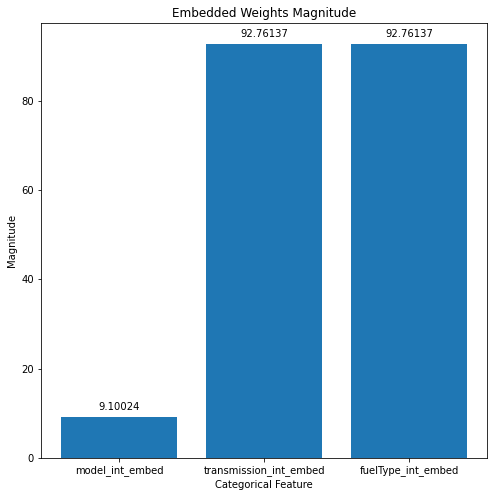

In [71]:
#https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.5f}'.format(height),
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 5),  # 5 points vertical offset
            textcoords="offset points",
            ha='center', va='bottom')
        
#plot embedded weights
fig, ax = plt.subplots(figsize=(8,8))

ax.set_xticks(range(len(reduced_w)))
ax.set_xticklabels(embeddings)
ax.set_title('Embedded Weights Magnitude')
ax.set_xlabel('Categorical Features')
ax.set_ylabel('Magnitude')

avg_w = [np.absolute(np.mean(w)) for w in reduced_w]
bar = ax.bar(range(len(reduced_w)), avg_w)

autolabel(bar)
plt.show()

In the bar chart, we can see the magnitude of the weights for the deep branch. Transmission and fuel type have the greatest and equal magnitude, so we can assume these features are equally good predictors for the log price. The model has the lowest magnitude, which could mean that this feature had lower influence in predicting the price.